In [31]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import scipy  # type: ignore
import pandas as pd # type: ignore
import os

# 将工作目录设置为 ../ 目录
os.chdir('c:/Users/dell/Desktop/24_11_work/Phase_Curve_2_TMap')
print(os.getcwd())

def fit_function(x, F0, C1, D1, C2, D2):  # Fitting Function
    # Cowan, Nicolas B., and Eric Agol. “Inverting Phase Functions to Map Exoplanets.” 
    # The Astrophysical Journal 678, no. 2 (May 10, 2008): L129–32.
    # https://doi.org/10.1086/588553.
    return F0 + C1*np.cos(x) + D1*np.sin(x) + C2*np.cos(2*x) + D2*np.sin(2*x)   # 到二阶
    

class PHASE_CURVE:  # Phase Curve Class
    class FITS: # Fits Class, stores the fitting parameters of the phase curve
        def __init__(self, parent, F0, C1, D1, C2, D2, pcov):
            self.parent = parent # parent class reference
            self.F0 = F0
            self.C1 = C1
            self.D1 = D1
            self.C2 = C2
            self.D2 = D2
            self.pars = np.array([F0, C1, D1, C2, D2])
            # self.chi_square = np.sum(((self.parent.fit_function(self.parent.phase, F0, C1, D1, C2, D2) - self.parent.contrast_ratio)**2)/np.diag(pcov))
            # self.perr = np.sqrt(np.diag(pcov))
            
    class SYS_PARS: # System Parameters Class, stores the parameters of planet and star
        def __init__(self, Nline):
            data_base = pd.read_csv('./data/PS.csv', header = 96)
            row_data = data_base.iloc[Nline]
            ### orbital parameters
            self.AU = 149597870.7  # km, Astronomical Unit
            self.Rs = row_data['st_rad'] * 696340  # km, radius of the Star
            self.Rp = row_data['pl_rade'] * 6371.4  # km, radius of the Planet
            self.eccentricity = 0 # row_data['pl_orbeccen'] # Eccentricity of the planet's orbit
            self.semi_axis = row_data['pl_orbsmax'] * self.AU  # km, semi-major axis of the planet's orbit
            ### Thermal and optical parameters
            self.Stellar_T = row_data['st_teff'] # K, temperature of the Star
            # self.pl_eqT = row_data['pl_eqt']  # K, fully redistribution, planet equilibrium Temperature [K] (from database)
            self.pl_eqT = self.Stellar_T * np.sqrt(self.Rs / 2 /self.semi_axis)  # from theoretical calculation
            
    def __init__(self, x_data, y_data):
        # Initialization of Phase Curve Class
        self.phase = x_data # orbital phase data
        self.contrast_ratio = y_data # contrast ratio data
        self.type = "Phase Curve" # type of data
        
        popt, pcov = scipy.optimize.curve_fit(fit_function, self.phase, self.contrast_ratio) # fitting the phase curve
        self.Fits = self.FITS(self, *popt, pcov) # storing the fitting parameters
        self.Sys_Pars = self.SYS_PARS(733 - 98)

    
    def Plot(self):  # Plotting Function
        plt.figure(figsize=(10, 6))
        plt.plot(self.phase, self.contrast_ratio, 'o', label='data')
        phase_list = np.linspace(-np.pi, np.pi, 100)
        plt.plot(phase_list, fit_function(phase_list, *self.Fits.pars), label='fit')
        plt.xlabel('Phase')
        plt.ylabel('Contrast Ratio')
        plt.legend()
        plt.show()



c:\Users\dell\Desktop\24_11_work\Phase_Curve_2_TMap


In [32]:
class TO_MAP:  # TMap Class
    def __init__(self, phase_curve):
        self.phase_curve = phase_curve
        self.T_pars = self.inversion(phase_curve.Fits.pars)
        
    def inversion(self, pars):
        # Cowan, Nicolas B., and Eric Agol. “Inverting Phase Functions to Map Exoplanets.” Journal of Geophysical Research 102.4 (1997): 8365–8378.
        coeff = np.array([2, np.pi/2, -np.pi/2, 2/3, -2/3])
        return coeff * pars
    
    def Plot(self):  # Plotting Function
        plt.figure(figsize=(10, 6))
        phase_list = np.linspace(-np.pi, np.pi, 100)
        plt.plot(phase_list, fit_function(phase_list, *self.T_pars), label='Brightness Temperature Map')
        plt.xlabel('Phase')
        plt.ylabel('Brightness Temperature')
        plt.legend()
        plt.show()
        

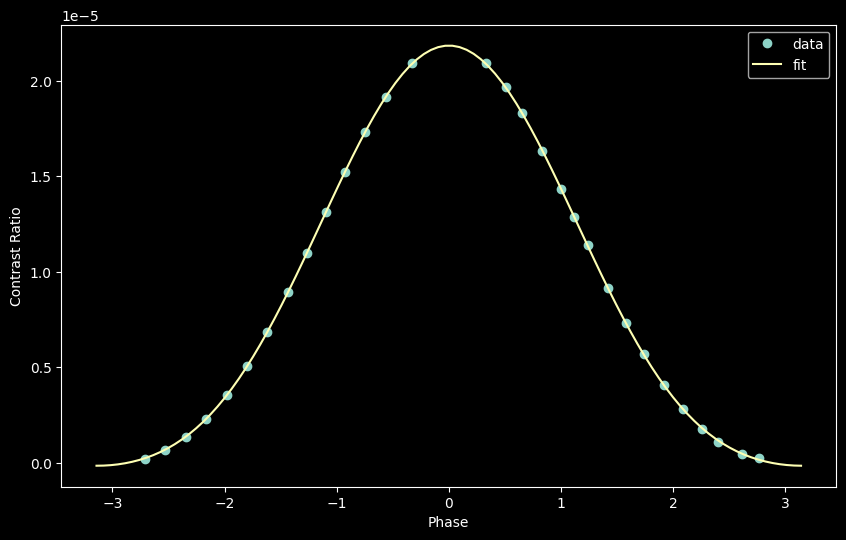

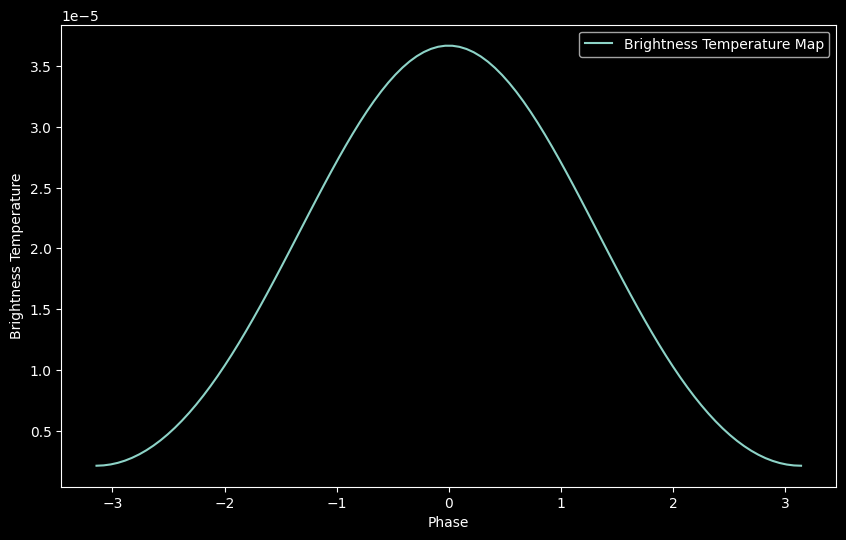

In [33]:
# Load the phase curve data from .txt file
file_path = './data/pc_theory.txt'
data = np.loadtxt(file_path, delimiter=',')  # load the data from .txt file
# data按照第一列从小到大排序
data = data[data[:, 0].argsort()]  # sort the data by phase
x_data = (data[:, 0] - 0.5) * 2 * np.pi  # phase data
y_data = data[:, 1] * 1e-6  # contrast ratio data
phase_curve = PHASE_CURVE(x_data, y_data)  # Create a Phase Curve object
phase_curve.Plot()  # Plot the Phase Curve

# convert the phase curve to a brightness temperature map
tmap = TO_MAP(phase_curve)
tmap.Plot()  # Plot the Brightness Temperature Map

